# 2. Data Story Telling: Electric Load Forecasting

This note book will cover the exploratory data analysis (EDA) part of a load forecasting project. We will load, investigate and make sense of the data. 
<p>&nbsp;</p>
We have three datasets that will be needed for this project. The three datasets are:

- Hourly electric load consumption data
- Historic weather data and 
- Texas daily Covid19 confirmed and deaths dataset


Before loading the dataset, import relevant libraries

## 2.1 Contents
 * 2  [Exploratory Data Analysis (EDA)](#2-Exploratory-Data-Analysis-(EDA))  
 * 2.1  [Contents](#2.1-Contents)  
 * 2.2  [Import libraries](#2.2-Import-libraries)  
 * 2.3  [Load cleaned energy consumption dataset](#2.3-Load-cleaned-energy-consumption-dataset)  
    * 2.3.1 [Data visualization](#2.3.1-Data-visualization)
 * 2.4  [Load cleaned historic weather dataset](#2.4-Load-cleaned-historic-weather-dataset)
    * 2.4.1 [Rename cities by region names](#2.4.1-Rename-cities-by-region-names)
    * 2.4.2 [Create apparent temperature feature](#2.4.2-Create-apparent-temperature-feature)
    * 2.4.3 [Interpolate the weather data](#2.4.3-Interpolate-the-weather-data)
        * 2.4.3.1 [Interpolation by forward fill (ffill())](#2.4.3.1-Interpolation-by-forward-fill-(ffill()))
        * 2.4.3.2 [Interpolation by mean](#2.4.3.2-Interpolation-by-mean)
        * 2.4.3.3 [Loading a sample of actual hourly weather data](#2.4.3.3-Loading-a-sample-of-actual-hourly-weather-data)
        * 2.4.3.4 [Visualization & comparison of interpolated data](#2.4.3.4-Visualization-&-comparison-of-interpolated-data)
        * 2.4.3.4 [Interpolate the whole weather data](#2.4.3.5-Interpolate-the-whole-weather-data)
 * 2.5 [Load cleaned Covid19 dataset](#2.5-Load-cleaned-Covid19-dataset)
    * 2.5.1 [Visualizing Covid19 data](#2.5.1-Visualizing-Covid19-data)
    * 2.5.2 [Interpolate Covid19 data](#2.5.2-Interpolate-Covid19-data)
 * 2.6 [Merging weather, covid and electric load datasets](#2.6-Merging-weather,-covid-and-electric-load-datasets)
 * 2.7 [Saving datasets](#2.7-Saving-datasets)
 * 2.8 [Summary](#2.8-Summary)


## 2.2 Import libraries

In [1]:
# Import relevant libraries
import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as cal
from pandas.tseries.offsets import CustomBusinessDay, BDay

import pickle
# plt.style.use('bmh')
plt.style.use('ggplot')

## 2.3 Load cleaned energy consumption dataset

In [2]:
# Load the cleaned energy consumption data
hourly_load_cleaned = pd.read_csv('./modified_data/ercot_hourly_cleaned.csv')

In [3]:
hourly_load_cleaned.head()

,Date,Coast,East,Far West,North,North Central,South,South Central,West,dates,hour,day,month,year,weekday,holiday,working_day
0,2005-01-01 01:00:00,7507.810731,850.313988,998.465500,741.963778,7312.259820,1883.979457,3728.400885,692.294503,2005-01-01 00:00:00,1,1,1,2005,Saturday,0,0
1,2005-01-01 02:00:00,7257.549136,818.143264,987.532852,711.996586,7012.466197,1798.234153,3562.614723,675.176013,2005-01-01 00:00:00,2,1,1,2005,Saturday,0,0
2,2005-01-01 03:00:00,6973.987199,783.396624,978.575662,687.881144,6712.807281,1712.758395,3373.868049,659.650453,2005-01-01 00:00:00,3,1,1,2005,Saturday,0,0
3,2005-01-01 04:00:00,6794.489296,760.639635,959.486947,673.419383,6502.378446,1651.210254,3239.047417,648.512894,2005-01-01 00:00:00,4,1,1,2005,Saturday,0,0
4,2005-01-01 05:00:00,6685.186677,743.371691,955.268590,664.792118,6440.559639,1627.872766,3176.859720,647.001780,2005-01-01 00:00:00,5,1,1,2005,Saturday,0,0


In [4]:
hourly_load_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144335 entries, 0 to 144334
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           144335 non-null  object 
 1   Coast          144335 non-null  float64
 2   East           144335 non-null  float64
 3   Far West       144335 non-null  float64
 4   North          144335 non-null  float64
 5   North Central  144335 non-null  float64
 6   South          144335 non-null  float64
 7   South Central  144335 non-null  float64
 8   West           144335 non-null  float64
 9   dates          144335 non-null  object 
 10  hour           144335 non-null  int64  
 11  day            144335 non-null  int64  
 12  month          144335 non-null  int64  
 13  year           144335 non-null  int64  
 14  weekday        144335 non-null  object 
 15  holiday        144335 non-null  int64  
 16  working_day    144335 non-null  int64  
dtypes: float64(8), int64(6), obje



The datetime format was not preserved when the csv file was saved. The date time information will be converted to a proper datetime format

In [5]:
# Convert the date to datetime64[ns] format and make the data as the index of the dataframe
hourly_load_cleaned['Date'] = hourly_load_cleaned['Date'].apply(lambda x : pd.to_datetime(x[:-6]))
hourly_load_cleaned.set_index('Date', inplace=True)

In [6]:
hourly_load_cleaned['dates'] = hourly_load_cleaned['dates'].apply(lambda x : pd.to_datetime(x[:-6]))
hourly_load_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144335 entries, 2005-01-01 01:00:00 to 2021-06-20 00:00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Coast          144335 non-null  float64       
 1   East           144335 non-null  float64       
 2   Far West       144335 non-null  float64       
 3   North          144335 non-null  float64       
 4   North Central  144335 non-null  float64       
 5   South          144335 non-null  float64       
 6   South Central  144335 non-null  float64       
 7   West           144335 non-null  float64       
 8   dates          144335 non-null  datetime64[ns]
 9   hour           144335 non-null  int64         
 10  day            144335 non-null  int64         
 11  month          144335 non-null  int64         
 12  year           144335 non-null  int64         
 13  weekday        144335 non-null  object        
 14  holiday        144

In [7]:
hourly_load_cleaned.index.inferred_type == "datetime64"

True

In [8]:
hourly_load_cleaned.dates.dtype == "datetime64[ns]"

True

### 2.3.1 Data Visualization

In the previous section we have seen some preliminary data visulaization. More comprehensive data visulaization will be done

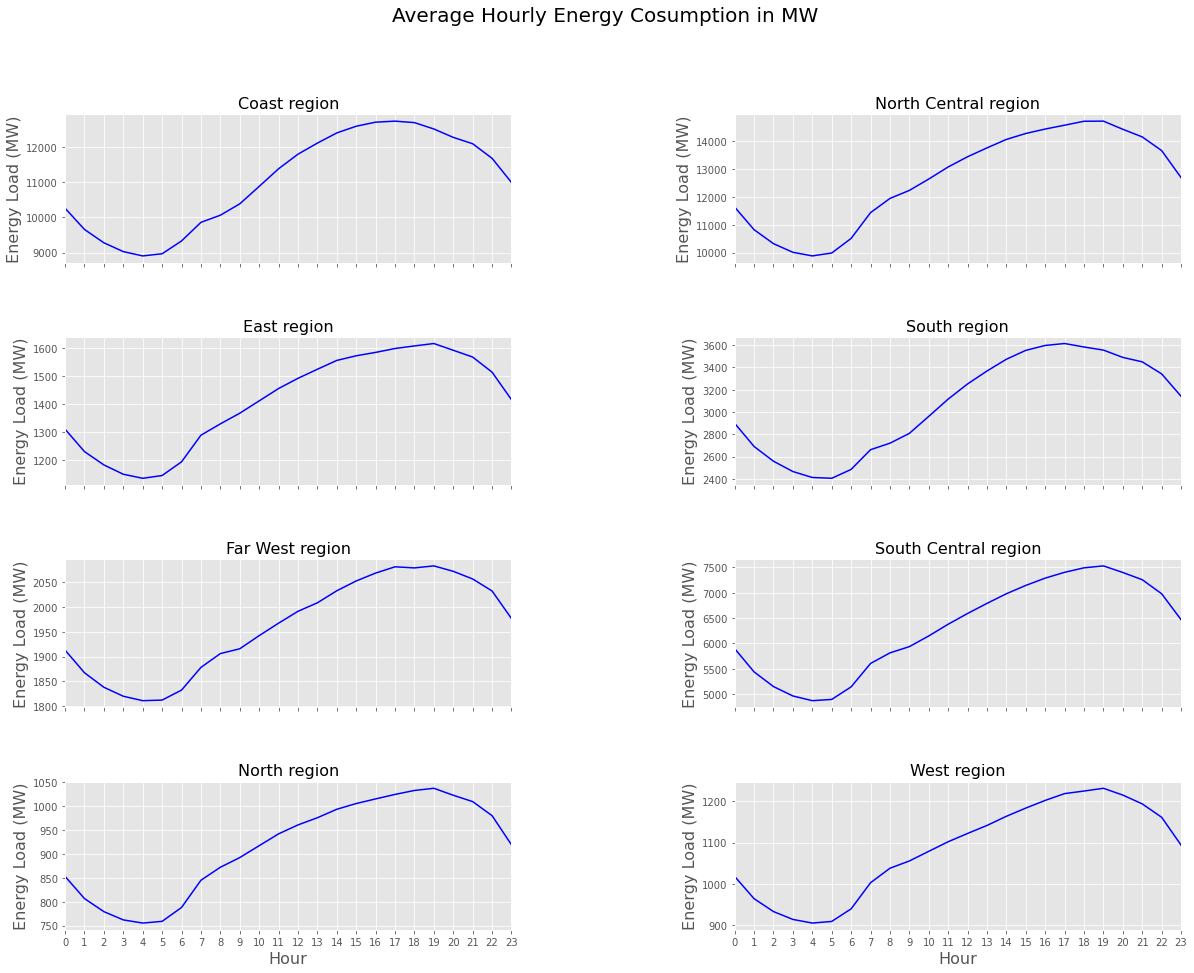

In [18]:
# Plotting Average yearly, monthly and hourly energy consumption
regions = ['Coast','East','Far West','North','North Central','South','South Central','West']
# regions = ['Coast']
k = 0
fig, ax = plt.subplots(4,2,figsize=(20,15))
# fig, ax = plt.subplots(1,1,figsize=(15,5))
for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    hourly_load_cleaned.groupby('hour')[region].mean().plot(ax = ax[i,k], 
            sharex=True,label = 'region = %s'%region, c='b')
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %region, fontsize=16)
    ax[i,k].set_xlabel('Hour', fontsize=16)
    ax[i,k].set_ylabel('Energy Load (MW)', fontsize=16)
    ax[i,k].set_xticks(hourly_load_cleaned.hour.unique())
    ax[i,k].set_xlim([0,max(hourly_load_cleaned.hour.unique())])
    plt.suptitle('Average Hourly Energy Cosumption in MW', fontsize=20)

# hourly_load_cleaned.groupby('hour')['Coast'].mean().plot(ax = ax, 
#         sharex=True,label = 'region = Coast', c='b')
# plt.subplots_adjust(hspace= 0.5, wspace =0.5)
# ax.set_title('Coast region', fontsize=16)
# ax.set_xlabel('Hour', fontsize=16)
# ax.set_ylabel('Energy Load (MW)', fontsize=16)
# ax.set_xticks(hourly_load_cleaned.hour.unique())
# ax.set_xlim([0,max(hourly_load_cleaned.hour.unique())])
# plt.savefig('./Images_4Report&Presentation/average_hourly_load_consumption.png', dpi=300, bbox_inches='tight')

plt.show()

The average hourly energy consumption plot for all regions is similar (note that the Y scale are different). The energy demand is low during the night hours (as people sleep) and then it starts to go up starting the morning hours and increase steadily through out the day with the peak demand around late evening when people return home from work. The reason for this peak energy consumption during late evening is lots of people will utilize energy hungry house hold equipments, such as, wash and dryer, dish washer, air conditioning, etc


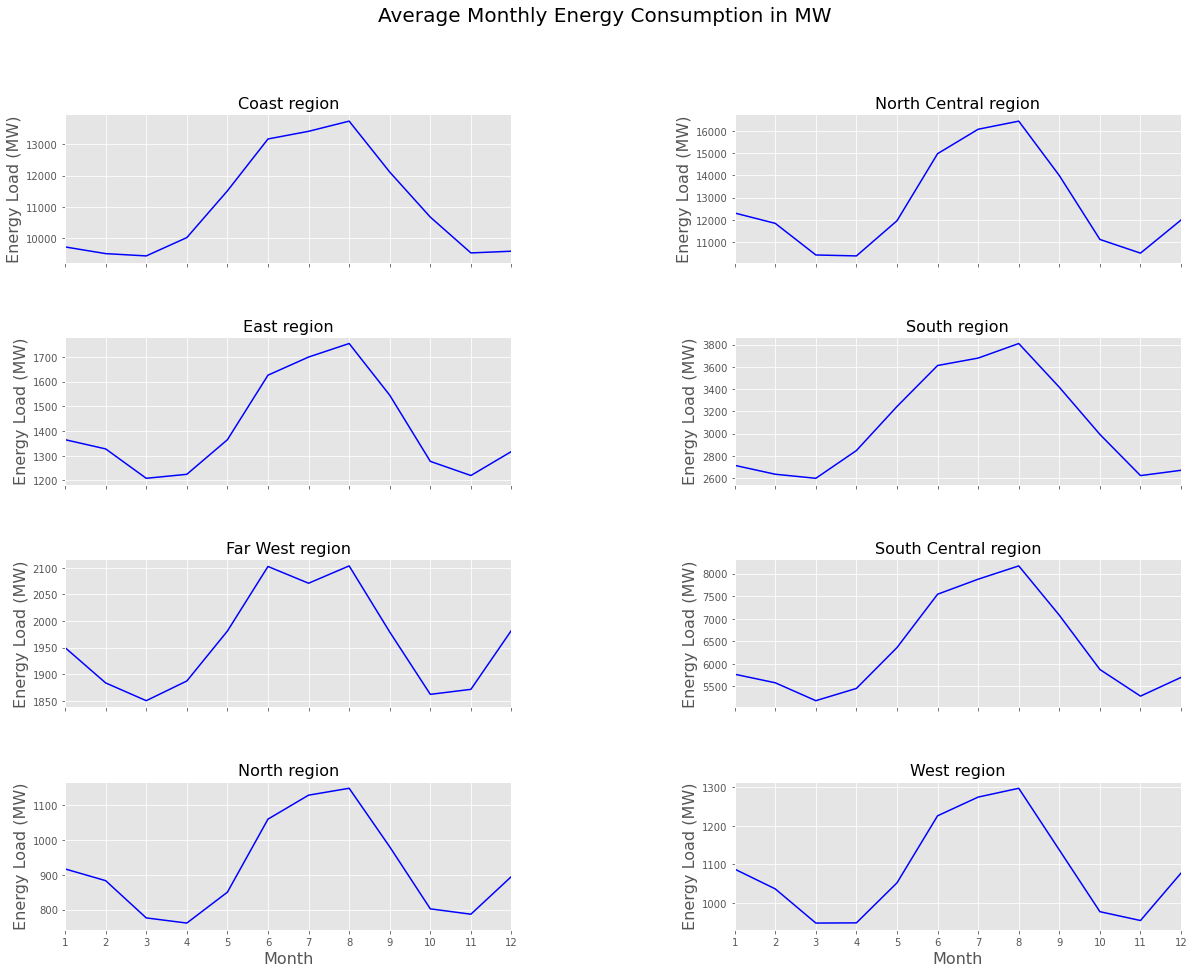

In [32]:
# Plotting Average monthly energy consumption
regions = ['Coast','East','Far West','North','North Central','South','South Central','West']
# regions = ['Coast','North Central']

k = 0
fig, ax = plt.subplots(4,2,figsize=(20,15))

for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    hourly_load_cleaned.groupby('month')[region].mean().plot(ax = ax[i,k], 
            sharex=True,label = 'region = %s'%region, c='b')
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %region, fontsize=16)
    ax[i,k].set_xlabel('Month', fontsize=16)
    ax[i,k].set_ylabel('Energy Load (MW)', fontsize=16)
    ax[i,k].set_xticks(hourly_load_cleaned.month.unique())
    ax[i,k].set_xlim([1, max(hourly_load_cleaned.month)])
    plt.suptitle('Average Monthly Energy Consumption in MW', fontsize=20)

    
#     hourly_load_cleaned.groupby('month')[region].mean().plot(ax = ax[i], 
#             sharex=True,label = 'region = %s'%region, c='b')
#     plt.subplots_adjust(hspace= 0.5, wspace =0.5)
#     ax[i].set_title('%s region' %region, fontsize=16)
#     ax[i].set_xlabel('Month', fontsize=16)
#     ax[i].set_ylabel('Energy Load (MW)', fontsize=16)
#     ax[i].set_xticks(hourly_load_cleaned.month.unique())
#     ax[i].set_xlim([1, max(hourly_load_cleaned.month)])
#     plt.suptitle('Average Monthly Energy Consumption in MW', fontsize=20)
#     k = k+1
    plt.savefig('./Images_4Report&Presentation/average_monthly_load_consumption_all.png', dpi=300, bbox_inches='tight')
plt.show()

Some observation from the average monthly energy demand:

- As expected, all the regions have the highest demand during the summer month. This coincides with the hot summer of Texas. the energy demands starts to increase starting may reaches the peak during July and August. Starting September there is a steady decrease during the fall.
- All regions, except the Coast and South regions, show mild increase in electric demand during the winter months of December up to February. The Coast and South regions have a mild or sometimes none-existent winter months (geographically they are the southern most regions), hence we don't see that much increase in electricity demand during the winter months.
- The Far-West region shows an interesting small dip in electricity demand during the peak of the summer. This is some what surprising. As of now I don't have a good reason as to why this region shows this behavior but will be investigated.

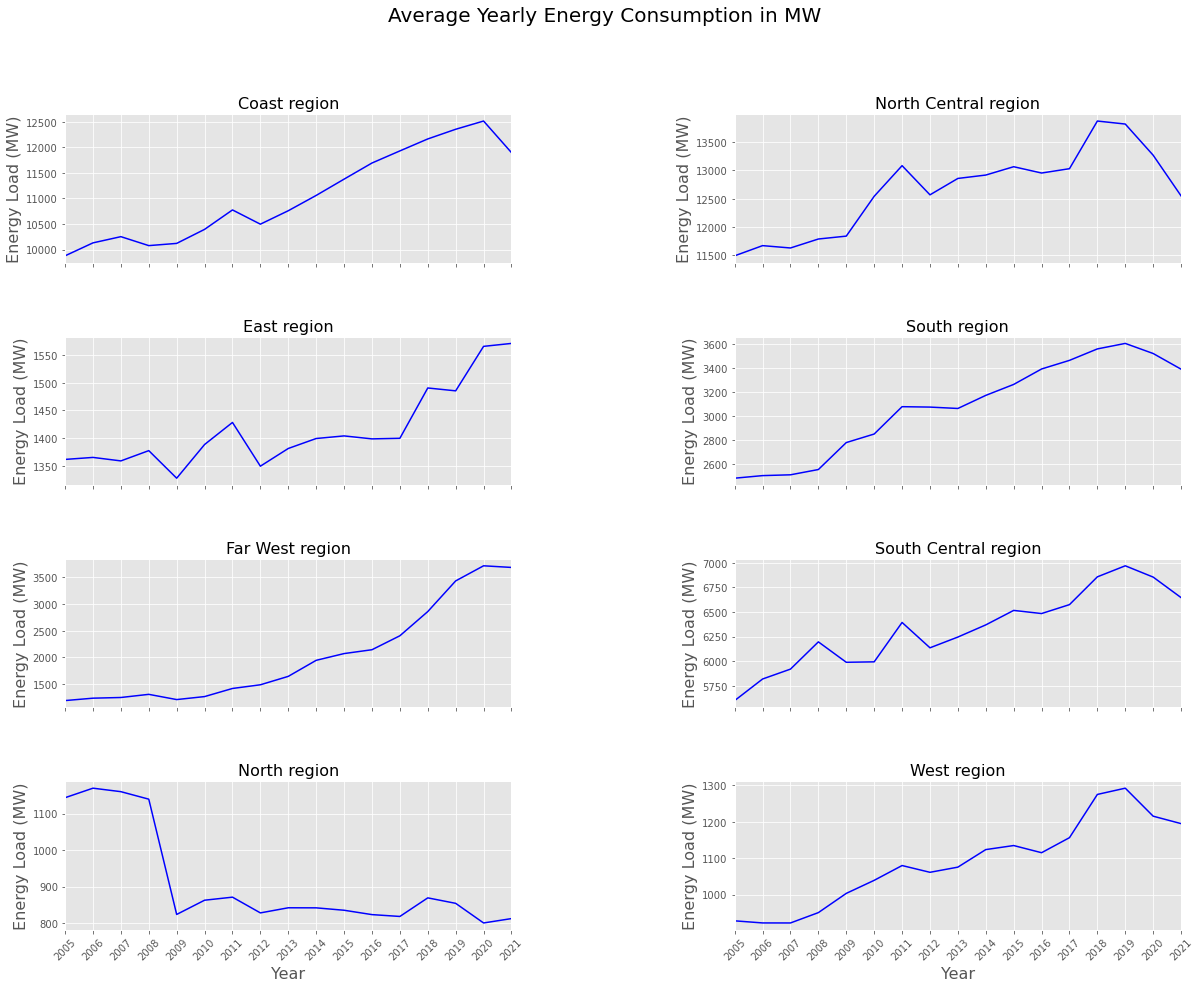

In [33]:
# Plotting Average yearly energy consumption
regions = ['Coast','East','Far West','North','North Central','South','South Central','West']

k = 0
fig, ax = plt.subplots(4,2,figsize=(20,15))

for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    hourly_load_cleaned.groupby('year')[region].mean().plot(ax = ax[i,k], sharex=True,c='b')
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %region, fontsize=16)
    ax[i,k].set_xlabel('Year', fontsize=16)
    ax[i,k].set_ylabel('Energy Load (MW)', fontsize=16)
    ax[i,k].set_xticks(hourly_load_cleaned.year.unique())
    ax[i,k].set_xticklabels(hourly_load_cleaned.year.unique(), rotation = 45)
    ax[i,k].set_xlim([min(hourly_load_cleaned.year), max(hourly_load_cleaned.year)])
    plt.suptitle('Average Yearly Energy Consumption in MW', fontsize=20)
    plt.savefig('./Images_4Report&Presentation/average_yearly_load_consumption_all.png', dpi=300, bbox_inches='tight')

plt.show()

The yearly average energy demand show some variability between regions.
- All the regions except, the North, show steady increase in energy demand until 2019 or 2020 in some cases. The dip in demand in 2020 and 2021 could be related to Covid19 outbreak. This means we need to de-trend out data to use the ARIMA type prediction modeling, as they assume stationarity of the time-series.
- The plot for the North region is a strange one. Energy consumption was very high around 2005 - 2008 and it decrease sharply by about 30% in 2009 and it remains almost flat after wards. Again I am not sure what happened then but it needs investigation. Regardless of the reason for this decrease, care must be taken when using this data for modeling and training.
- Another interesting observation is, there is a small spike in energy demand in 2011 in most of the regions, most easily visible in North Central, South Central, East, Coast and South regions.

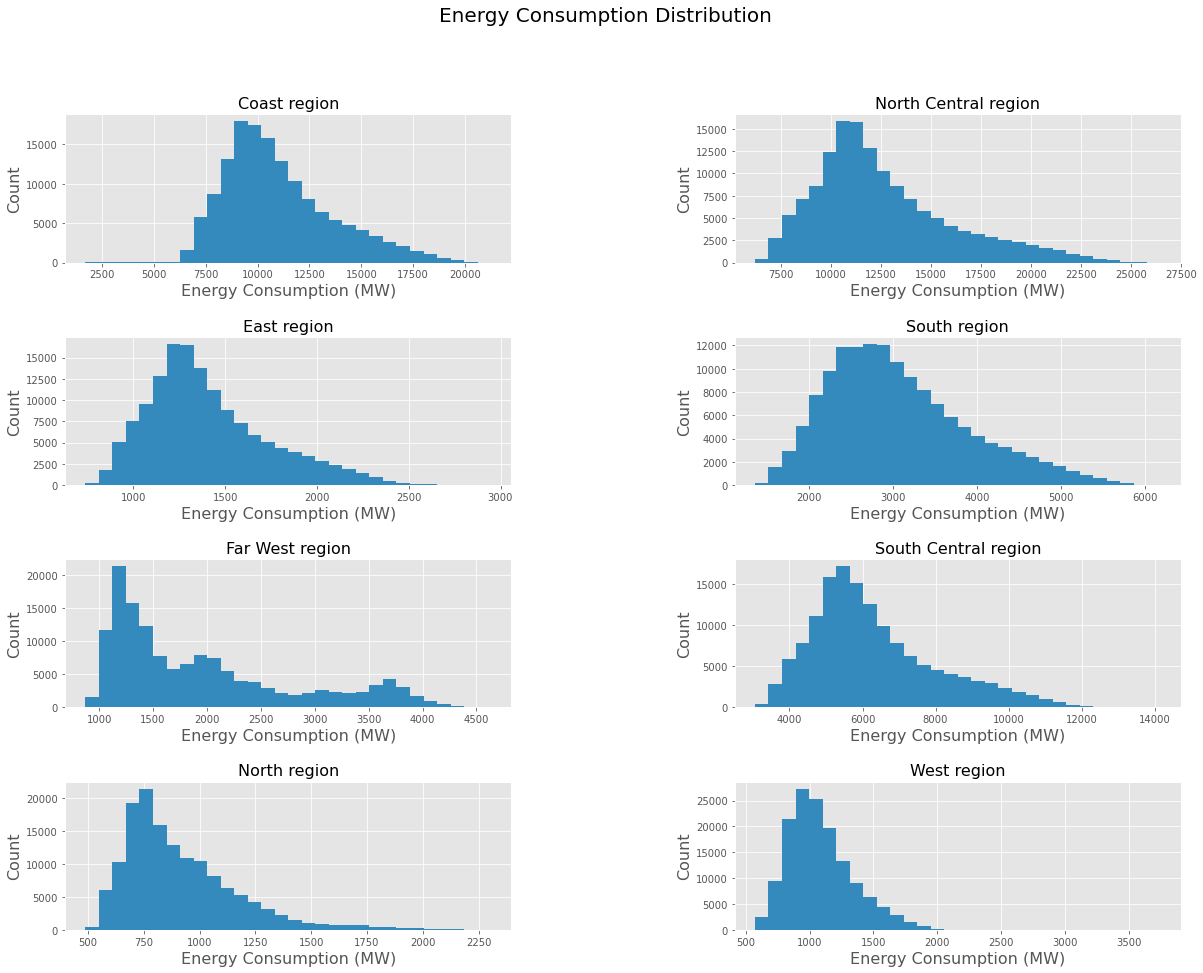

In [12]:
# Plotting histogram energy consumption
regions = ['Coast','East','Far West','North','North Central','South','South Central','West']

k = 0
fig, ax = plt.subplots(4,2,figsize=(20,15))

for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    hourly_load_cleaned[region].hist(ax = ax[i,k], bins=30, label = 'region = %s'%region, color = 'C1')
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %region, fontsize=16)
    ax[i,k].set_xlabel('Energy Consumption (MW)', fontsize=16)
    ax[i,k].set_ylabel('Count', fontsize=16)
#     ax[i,k].set_xticks(hourly_load_cleaned.year.unique())
#     ax[i,k].set_xticklabels(hourly_load_cleaned.year.unique(), rotation = 45)
#     ax[i,k].set_xlim([min(hourly_load_cleaned.year), max(hourly_load_cleaned.year)])
    plt.suptitle('Energy Consumption Distribution', fontsize=20)

plt.show()

The distribution is mostly uni-modal with a right tail. However, the distribution for the Far West is tri-modal. One large peak and two small peaks to the right. the Far West region also has a very long right tail

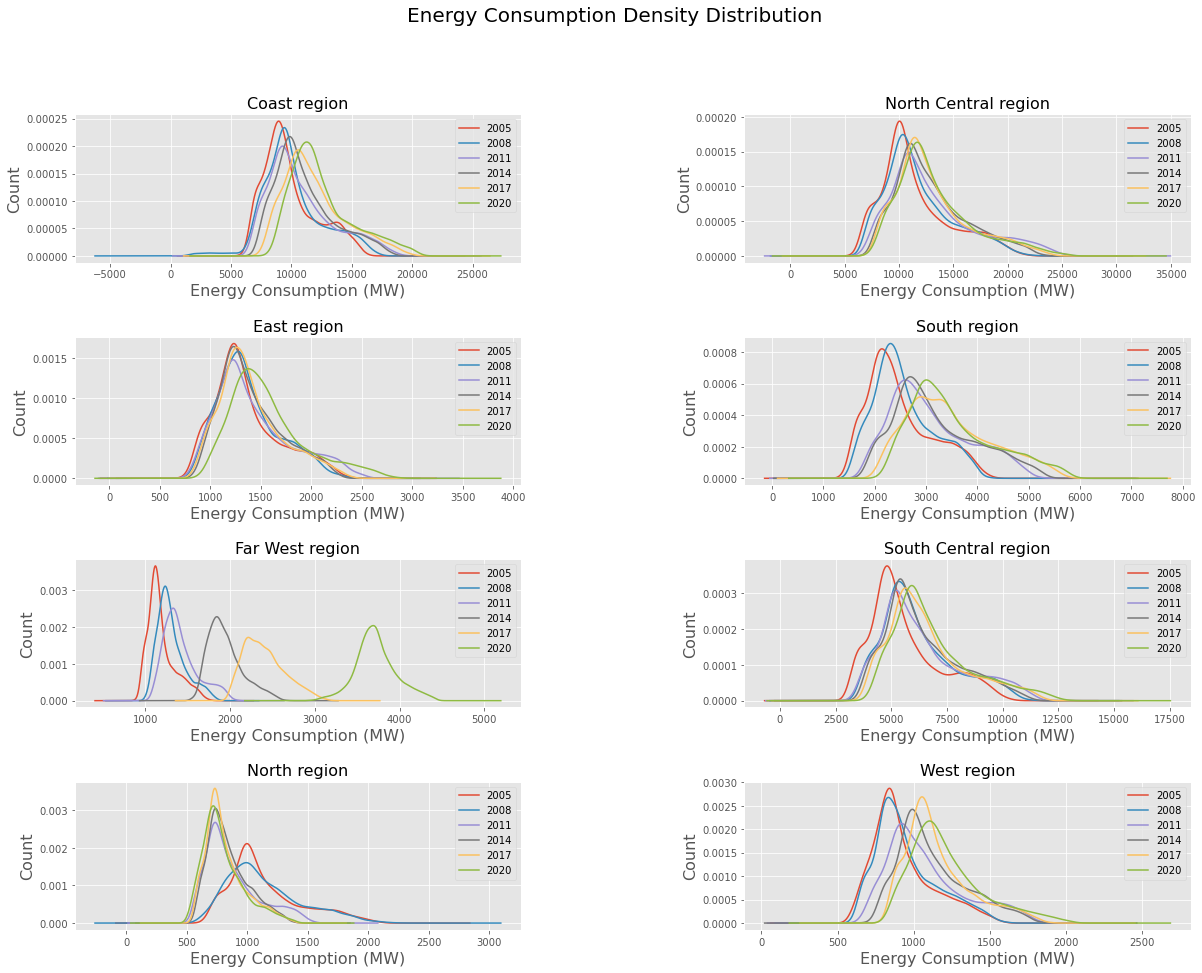

In [13]:
# Plotting denisty distribution by year energy consumption
# The plot will be every 3 years to avoid cluttering

regions = ['Coast','East','Far West','North','North Central','South','South Central','West']

k = 0
fig, ax = plt.subplots(4,2,figsize=(20,15))
years = np.arange(2005,2021,3)
for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    for year in years: 
        hourly_load_cleaned[hourly_load_cleaned['year'] == year][region].plot(
            ax = ax[i,k], kind = 'density', legend = True, label = year)
        plt.subplots_adjust(hspace= 0.5, wspace =0.5)
        ax[i,k].set_title('%s region' %region, fontsize=16)
        ax[i,k].set_xlabel('Energy Consumption (MW)', fontsize=16)
        ax[i,k].set_ylabel('Count', fontsize=16)
#     ax[i,k].set_xticks(hourly_load_cleaned.year.unique())
#     ax[i,k].set_xticklabels(hourly_load_cleaned.year.unique(), rotation = 45)
#     ax[i,k].set_xlim([min(hourly_load_cleaned.year), max(hourly_load_cleaned.year)])
        plt.suptitle('Energy Consumption Density Distribution', fontsize=20)

plt.show()

The density distribution shows right tail distribution, the same as the total histogram distribution. Observations include : 
- With the exception of the North region, all other regions distribution shifted to the right as we move from 2005 to 2021, indicating increase in energy consumption with time. The North region however shows opposite of this trend. The density distribution shifted to the left after 2008 and remained stead after that.
- The Far West region's density distribution shifted to the right but with different shift rate. It shows steady shift to the right from 2005 to 2011, then there is a big lateral shift to the right starting 2014. Also the rate of shift seems to increase every year. This was also observed in the average yearly energy consumption plot. The upward trend observed seems to have some exponenetial trend to it.

In [14]:
hourly_load_cleaned.head()

,Coast,East,Far West,North,North Central,South,South Central,West,dates,hour,day,month,year,weekday,holiday,working_day
Date,,,,,,,,,,,,,,,,
2005-01-01 01:00:00,7507.810731,850.313988,998.465500,741.963778,7312.259820,1883.979457,3728.400885,692.294503,2005-01-01,1,1,1,2005,Saturday,0,0
2005-01-01 02:00:00,7257.549136,818.143264,987.532852,711.996586,7012.466197,1798.234153,3562.614723,675.176013,2005-01-01,2,1,1,2005,Saturday,0,0
2005-01-01 03:00:00,6973.987199,783.396624,978.575662,687.881144,6712.807281,1712.758395,3373.868049,659.650453,2005-01-01,3,1,1,2005,Saturday,0,0
2005-01-01 04:00:00,6794.489296,760.639635,959.486947,673.419383,6502.378446,1651.210254,3239.047417,648.512894,2005-01-01,4,1,1,2005,Saturday,0,0
2005-01-01 05:00:00,6685.186677,743.371691,955.268590,664.792118,6440.559639,1627.872766,3176.859720,647.001780,2005-01-01,5,1,1,2005,Saturday,0,0


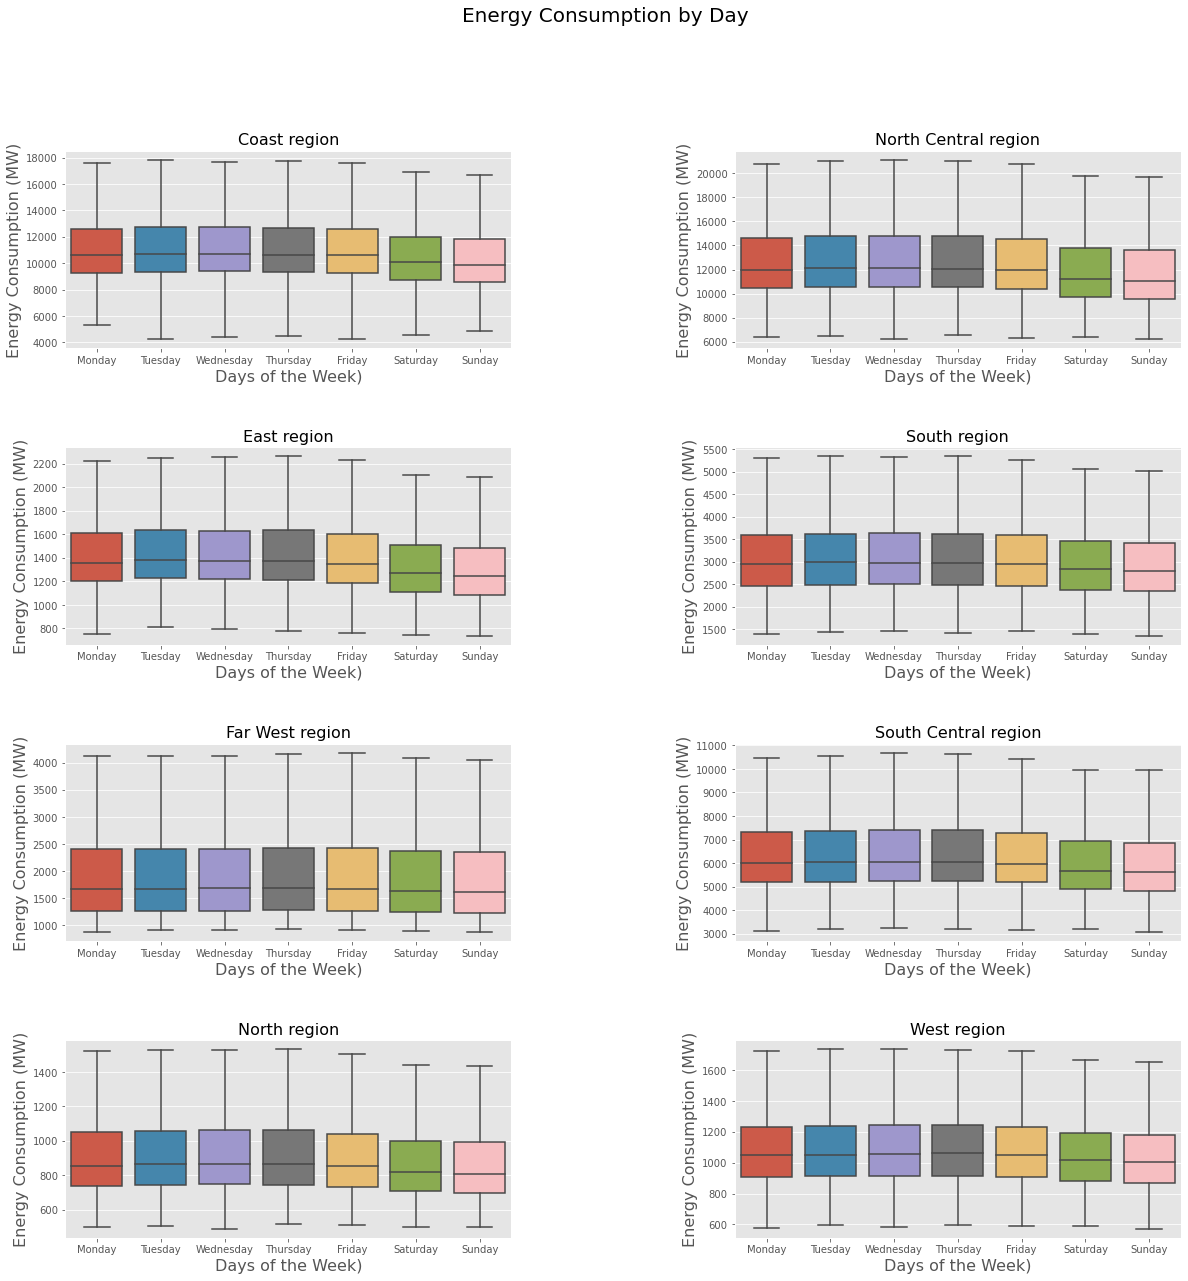

In [15]:
# plot load consumption for each day of the week. 
k = 0
fig, ax = plt.subplots(4,2,figsize=(20,20))

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday" ]


for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    sns.boxplot(x = 'weekday', y = hourly_load_cleaned[region], 
                data = hourly_load_cleaned, ax = ax[i,k], showfliers=False, order=order)
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %region, fontsize=16)
    ax[i,k].set_xlabel('Days of the Week)', fontsize=16)
    ax[i,k].set_ylabel('Energy Consumption (MW)', fontsize=16)
#     ax[i,k].set_xticks(hourly_load_cleaned.year.unique())
#     ax[i,k].set_xticklabels(hourly_load_cleaned.year.unique(), rotation = 45)
#     ax[i,k].set_xlim([min(hourly_load_cleaned.year), max(hourly_load_cleaned.year)])
    plt.suptitle('Energy Consumption by Day', fontsize=20)

plt.show()

The median electric load remains steady from Monday to Friday and decreases over the weekend. This reduction in energy consumption over the weekend is mostly due to closure of industries and offices for the week end. 
- Again the Far West region shows different behavior, the week end energy consumption does not change that much from the other working days. This could be explained if we know what are the main economic activity in the area. If there are industries, may be they don't close over the weekend. One of the main economic activity in the far West region is oil drilling and this oil rigs work 24/7 and thus the demand on electricity from this does not change daily.  ***??? this needs to be investigated more***

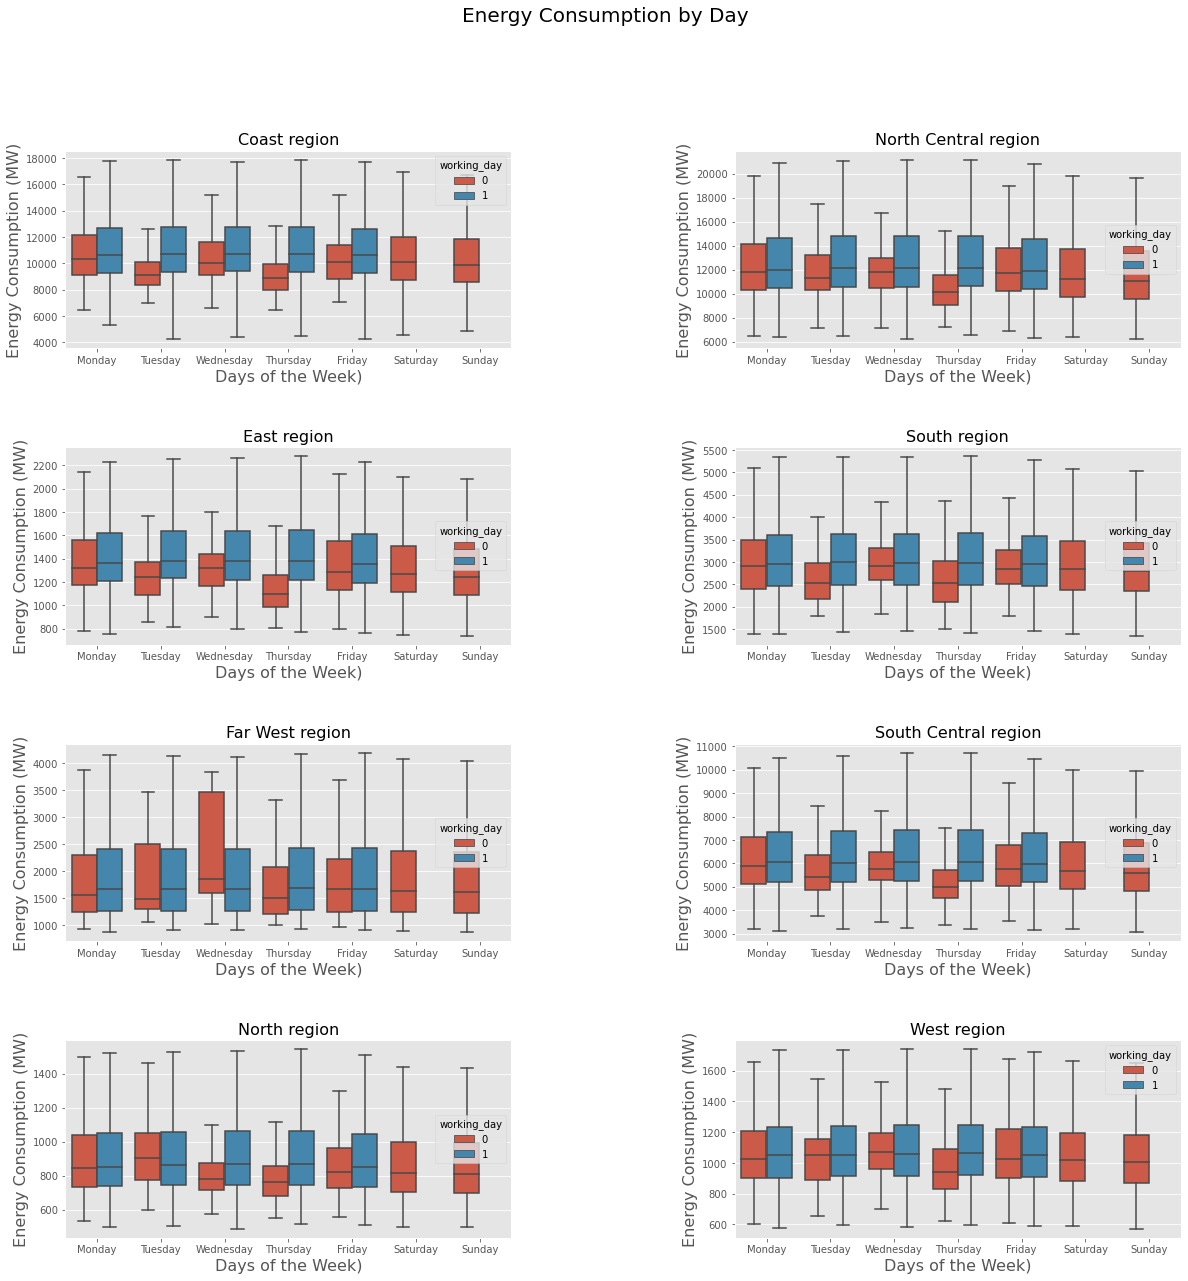

In [16]:
# plot load consumption for each day of the week separated by working and non-working day 
k = 0
fig, ax = plt.subplots(4,2,figsize=(20,20))

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday" ]


for i, region in enumerate(regions) :
    if i >= 4:
        i = i - 4
        k = 1
    sns.boxplot(x = 'weekday', y = hourly_load_cleaned[region], hue= 'working_day',
                data = hourly_load_cleaned, ax = ax[i,k], showfliers=False, order=order)
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %region, fontsize=16)
    ax[i,k].set_xlabel('Days of the Week)', fontsize=16)
    ax[i,k].set_ylabel('Energy Consumption (MW)', fontsize=16)
#     ax[i,k].set_xticks(hourly_load_cleaned.year.unique())
#     ax[i,k].set_xticklabels(hourly_load_cleaned.year.unique(), rotation = 45)
#     ax[i,k].set_xlim([min(hourly_load_cleaned.year), max(hourly_load_cleaned.year)])
    plt.suptitle('Energy Consumption by Day', fontsize=20)

# plt.legend('upper right')
plt.show()

If any give day happens to be a holiday, its energy consumption is lower than similar working day. Another observation is if the holiday happens to be on Monday (which makes it a long-weekend), the energy demand does not differ that much from a working Monday. You can also make a case for Friday as well.

Again the Far West has some an unexpected characteristics.

## 2.4 Load cleaned historic weather dataset

In [43]:
# Load the cleaned historic weather data
hist_weather_cleaned = pd.read_csv('./modified_data/weather_hist_cleaned.csv')

In [44]:
hist_weather_cleaned.head()

,Date,city,tempC,windspeedKmph,winddirDegree,winddir16Point,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,weatherCategory
0,2008-07-01 00:00:00,Abilene,21,7,173,S,0.0,63,10,1018,6,24,14,21,15,21,1,sunny
1,2008-07-01 00:00:00,Corpus Christi,26,12,146,SE,0.0,83,10,1017,7,28,23,26,21,28,1,sunny
2,2008-07-01 00:00:00,Dallas,25,9,149,SSE,0.0,46,10,1018,4,25,12,25,18,25,1,sunny
3,2008-07-01 00:00:00,Houston,27,5,4,N,2.2,81,9,1018,15,30,23,27,9,30,1,light_rain
4,2008-07-01 00:00:00,Midland,20,6,137,SE,0.0,74,10,1020,41,20,15,20,11,20,1,cloudy


In [45]:
# Convert the date to datetime64[ns] format and make the data as the index of the dataframe
hist_weather_cleaned['Date'] = hist_weather_cleaned['Date'].apply(lambda x : pd.to_datetime(x[:-6]))
hist_weather_cleaned.set_index('Date', inplace=True)

In [46]:
hist_weather_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303104 entries, 2008-07-01 00:00:00 to 2021-06-19 21:00:00
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   city             303104 non-null  object 
 1   tempC            303104 non-null  int64  
 2   windspeedKmph    303104 non-null  int64  
 3   winddirDegree    303104 non-null  int64  
 4   winddir16Point   303104 non-null  object 
 5   precipMM         303104 non-null  float64
 6   humidity         303104 non-null  int64  
 7   visibility       303104 non-null  int64  
 8   pressure         303104 non-null  int64  
 9   cloudcover       303104 non-null  int64  
 10  HeatIndexC       303104 non-null  int64  
 11  DewPointC        303104 non-null  int64  
 12  WindChillC       303104 non-null  int64  
 13  WindGustKmph     303104 non-null  int64  
 14  FeelsLikeC       303104 non-null  int64  
 15  uvIndex          303104 non-null  int64  
 16  weat

In [47]:
hist_weather_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
tempC,303104.0,19.969908,9.147925,-21.0,14.0,21.0,27.0,45.0
windspeedKmph,303104.0,14.919599,7.524118,0.0,9.0,14.0,19.0,80.0
winddirDegree,303104.0,160.778762,85.603621,0.0,110.0,161.0,199.0,360.0
precipMM,303104.0,0.405681,1.816512,0.0,0.0,0.0,0.0,127.9
humidity,303104.0,63.754108,21.729459,1.0,47.0,65.0,82.0,100.0
visibility,303104.0,9.313836,1.990838,0.0,10.0,10.0,10.0,10.0
pressure,303104.0,1015.815529,6.509573,985.0,1012.0,1015.0,1019.0,1049.0
cloudcover,303104.0,29.423356,32.677544,0.0,3.0,14.0,49.0,100.0
HeatIndexC,303104.0,21.020521,10.073825,-21.0,14.0,22.0,28.0,59.0
DewPointC,303104.0,11.812850,9.413122,-52.0,5.0,14.0,20.0,29.0


### 2.4.1 Rename cities by region names

The weather data is using city names instead of the region names. To be consistent with the electric data, we will assign the region names for each city in the weather data and rename the column city to region

In [48]:
regions = {'Houston':'Coast','Tyler':'East','Midland':'Far West','Wichita Falls':'North','Dallas':'North Central',
           'Corpus Christi':'South','San Antonio':'South Central','Abilene':'West'}

hist_weather_cleaned['city'] = hist_weather_cleaned['city'].map(regions)


In [54]:
# Rename the column name from city to region
hist_weather_cleaned.rename({'city':'region'},axis=1, inplace=True)
hist_weather_cleaned

,region,tempC,windspeedKmph,winddirDegree,winddir16Point,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,weatherCategory
Date,,,,,,,,,,,,,,,,,
2008-07-01 00:00:00,West,21,7,173,S,0.0,63,10,1018,6,24,14,21,15,21,1,sunny
2008-07-01 00:00:00,South,26,12,146,SE,0.0,83,10,1017,7,28,23,26,21,28,1,sunny
2008-07-01 00:00:00,North Central,25,9,149,SSE,0.0,46,10,1018,4,25,12,25,18,25,1,sunny
2008-07-01 00:00:00,Coast,27,5,4,N,2.2,81,9,1018,15,30,23,27,9,30,1,light_rain
2008-07-01 00:00:00,Far West,20,6,137,SE,0.0,74,10,1020,41,20,15,20,11,20,1,cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-19 21:00:00,Coast,31,12,235,SW,0.0,50,10,1009,3,34,20,31,15,34,1,cloudy
2021-06-19 21:00:00,Far West,32,21,164,SSE,0.0,24,10,1005,5,31,9,32,34,31,1,cloudy
2021-06-19 21:00:00,South Central,33,17,157,SSE,0.0,46,10,1008,5,36,16,33,27,36,1,cloudy


In [29]:
hist_weather_cleaned[hist_weather_cleaned['city'] == city]['tempC']

Date
2008-07-01 00:00:00    21
2008-07-01 03:00:00    21
2008-07-01 06:00:00    20
2008-07-01 09:00:00    27
2008-07-01 12:00:00    33
                       ..
2021-06-19 09:00:00    26
2021-06-19 12:00:00    31
2021-06-19 15:00:00    34
2021-06-19 18:00:00    35
2021-06-19 21:00:00    33
Name: tempC, Length: 37888, dtype: int64

### 2.4.2 Create apparent temperature feature

A feature that combines the effect of temperature, pressure, humidity and windspeed would be a good measure how people feel about the overall weather condiction. This feature is different than heat index, as the latter does not consider the effect of air pressure and wind speed. The formulas are adopted from this puplication (https://people.eng.unimelb.edu.au/smonazam/publications/Fahiman2019IJCNN.pdf)

The temperature that we feel determines the amount of energy that we use for cooling or heating. The air temperature is usually used as a measure of how comfortable we feel when we want to use heating or cooling appliances. However, the air temperature is only one of the factors that has an impact on the assessment of thermal stress. Where other factors, principally humidity and wind speed, can vary widely from day to day, we need to consider the effect of all factors to assess the level of comfort realistically.
Apparent Temperature (AT) is a useful index which condenses all the factors of perceived temperature into a single value and it can be calculated as:

                            AT = Ta + 0.33e − 0.7ws − 4
                            
where T a is the temperature ( ◦C), ws is wind speed in (m/s) and e is the water vapour pressure in (hPa) which can be calculated using the following formula:

                            e = (6.105rh/100) exp(17.27Ta/ (237.7 + Ta))
                            
where rh is the relative humidity (%).

In [302]:
# compute apparent temperature
vapour_press = (6.105*hist_weather_cleaned.humidity/100) * np.exp((17.27*hist_weather_cleaned.tempC)/(237.7 + hist_weather_cleaned.tempC))
hist_weather_cleaned['appr_temp'] = hist_weather_cleaned.tempC + 0.33*vapour_press - 0.7*hist_weather_cleaned.windspeedKmph*(10/36) - 4

Date
2008-07-01 00:00:00    15.626477
2008-07-01 00:00:00    27.814204
2008-07-01 00:00:00    14.528163
2008-07-01 00:00:00    28.788218
2008-07-01 00:00:00    17.258784
                         ...    
2021-06-19 21:00:00    22.385334
2021-06-19 21:00:00    11.371194
2021-06-19 21:00:00    23.055373
2021-06-19 21:00:00    27.366578
2021-06-19 21:00:00    19.163678
Length: 303104, dtype: float64


In [177]:
hist_weather_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303104 entries, 2008-07-01 00:00:00 to 2021-06-19 21:00:00
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   region           303104 non-null  object 
 1   tempC            303104 non-null  int64  
 2   windspeedKmph    303104 non-null  int64  
 3   winddirDegree    303104 non-null  int64  
 4   winddir16Point   303104 non-null  object 
 5   precipMM         303104 non-null  float64
 6   humidity         303104 non-null  int64  
 7   visibility       303104 non-null  int64  
 8   pressure         303104 non-null  int64  
 9   cloudcover       303104 non-null  int64  
 10  HeatIndexC       303104 non-null  int64  
 11  DewPointC        303104 non-null  int64  
 12  WindChillC       303104 non-null  int64  
 13  WindGustKmph     303104 non-null  int64  
 14  FeelsLikeC       303104 non-null  int64  
 15  uvIndex          303104 non-null  int64  
 16  weat

In [219]:
hist_weather_cleaned.head(24)

,region,tempC,windspeedKmph,winddirDegree,winddir16Point,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,weatherCategory,appr_temp
Date,,,,,,,,,,,,,,,,,,
2008-07-01 00:00:00,West,21,7,173,S,0.0,63,10,1018,6,24,14,21,15,21,1,sunny,20.795626
2008-07-01 00:00:00,South,26,12,146,SE,0.0,83,10,1017,7,28,23,26,21,28,1,sunny,28.845354
2008-07-01 00:00:00,North Central,25,9,149,SSE,0.0,46,10,1018,4,25,12,25,18,25,1,sunny,24.044294
2008-07-01 00:00:00,Coast,27,5,4,N,2.2,81,9,1018,15,30,23,27,9,30,1,light_rain,31.527890
2008-07-01 00:00:00,Far West,20,6,137,SE,0.0,74,10,1020,41,20,15,20,11,20,1,cloudy,20.528732
2008-07-01 00:00:00,South Central,25,10,130,SE,0.5,77,9,1017,17,27,21,25,18,27,1,light_rain,27.080786
2008-07-01 00:00:00,East,20,3,105,ESE,0.0,65,10,1018,4,20,13,20,7,20,1,sunny,20.419382
2008-07-01 00:00:00,North,26,16,186,S,0.0,37,10,1017,17,26,10,26,29,26,1,sunny,22.980593
2008-07-01 03:00:00,West,21,8,196,SSW,0.0,64,10,1017,6,21,13,21,17,21,1,sunny,20.683035



###  2.4.3 Interpolate the weather data

The weather data is sampled every 3 hours where as the electric load consumption dataset is every 1 hour. We need to resample and interpolate the weather data to a 1 hour frequency. We will test different method of interpolation including, ffill, bfill and mean. 

There are two issues for us to resample the weather data as it is.
- First, for every datetime index we have 8 duplicates corresponding to each region. Hence directly calling resample() will produce errors. A dictionary containing the region as a key and the dataframe corresponding to the region as a value 
- Second, if we want to use the average of the ffill and bfill, we have to manipulate the categorical columns in the dataframe


#### 2.4.3.1 Interpolation by forward fill (ffill())

To compare different interpolation methods vs the actual weather data, we will use only a subset of the data as an example. Once, we compare, visualize the results and select the interpolation method, we will proceed to interpolate the whole weather data by the desired interpolation method.  

In [303]:
# First create a sample dataframe grouped by regions and then assign each df by region into a dictionary
start_t = '2009-07-01'
end_t = '2009-07-09'

samp_weather_dict = {}
samp_weather_by_region = hist_weather_cleaned[start_t:end_t].groupby('region')
regions = hist_weather_cleaned['region'].unique()
for region in regions:
    samp_weather_dict[region] = samp_weather_by_region.get_group(region)   

In [304]:
samp_weather_dict['Coast'].head()

,region,tempC,windspeedKmph,winddirDegree,winddir16Point,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,weatherCategory,appr_temp
Date,,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,Coast,27,5,271,W,1.0,82,9,1009,6,31,24,27,8,31,1,light_rain,31.645175
2009-07-01 03:00:00,Coast,26,8,309,NW,0.0,84,10,1009,3,28,23,26,12,28,1,sunny,29.733718
2009-07-01 06:00:00,Coast,24,5,326,NW,0.0,81,10,1010,4,26,21,24,7,26,6,sunny,26.980567
2009-07-01 09:00:00,Coast,31,6,342,NNW,0.0,58,10,1011,6,34,21,31,7,34,8,sunny,34.402439
2009-07-01 12:00:00,Coast,35,4,0,N,0.0,44,10,1012,7,39,21,35,5,39,9,sunny,38.355819


In [305]:
# Comparison of interpolation methods. 
# We will use Coast region as an example

# First interpolation by ffill
resample_by_ffill = samp_weather_dict['Coast'].resample('1H').ffill()
resample_by_ffill.head()

,region,tempC,windspeedKmph,winddirDegree,winddir16Point,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,weatherCategory,appr_temp
Date,,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,Coast,27,5,271,W,1.0,82,9,1009,6,31,24,27,8,31,1,light_rain,31.645175
2009-07-01 01:00:00,Coast,27,5,271,W,1.0,82,9,1009,6,31,24,27,8,31,1,light_rain,31.645175
2009-07-01 02:00:00,Coast,27,5,271,W,1.0,82,9,1009,6,31,24,27,8,31,1,light_rain,31.645175
2009-07-01 03:00:00,Coast,26,8,309,NW,0.0,84,10,1009,3,28,23,26,12,28,1,sunny,29.733718
2009-07-01 04:00:00,Coast,26,8,309,NW,0.0,84,10,1009,3,28,23,26,12,28,1,sunny,29.733718


#### 2.4.3.2 Interpolation by mean

Interpolating by the average of the two conssecutive values is not straightforward especially if your dataframe contains categorical value. To get the average values, we interpolate by ffill anf bfill separetly and then divide by 2. This however does not work if you have categorical variables (you can not take average of two sting values). Therefore we will use the refult of the ffill for the categorical columns. 



In [306]:
# Interpolation by the mean of the two consecutive value
# This will be achieved by average ffill and bfill interpolation methods

resample_by_bfill = samp_weather_dict['Coast'].resample('1H').bfill()
category = resample_by_ffill[['region','winddir16Point','weatherCategory']]
resample_by_ffill.drop(columns={'region','winddir16Point','weatherCategory'}, inplace=True)
resample_by_bfill.drop(columns={'region','winddir16Point','weatherCategory'}, inplace=True)
resample_by_mean = (resample_by_ffill + resample_by_bfill) / 2
resample_by_mean['region'] = category['region']
resample_by_mean['winddir16Point'] = category['winddir16Point']
resample_by_mean['weatherCategory'] = category['weatherCategory']

resample_by_mean.head()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,appr_temp,region,winddir16Point,weatherCategory
Date,,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,27.0,5.0,271.0,1.0,82.0,9.0,1009.0,6.0,31.0,24.0,27.0,8.0,31.0,1.0,31.645175,Coast,W,light_rain
2009-07-01 01:00:00,26.5,6.5,290.0,0.5,83.0,9.5,1009.0,4.5,29.5,23.5,26.5,10.0,29.5,1.0,30.689447,Coast,W,light_rain
2009-07-01 02:00:00,26.5,6.5,290.0,0.5,83.0,9.5,1009.0,4.5,29.5,23.5,26.5,10.0,29.5,1.0,30.689447,Coast,W,light_rain
2009-07-01 03:00:00,26.0,8.0,309.0,0.0,84.0,10.0,1009.0,3.0,28.0,23.0,26.0,12.0,28.0,1.0,29.733718,Coast,NW,sunny
2009-07-01 04:00:00,25.0,6.5,317.5,0.0,82.5,10.0,1009.5,3.5,27.0,22.0,25.0,9.5,27.0,3.5,28.357143,Coast,NW,sunny


#### 2.4.3.3 Loading a sample of actual hourly weather data

Now we will load the actual hourly weather data from the weatheronline API website (https://api.worldweatheronline.com/premium/v1/past-weather.ashx). We are loading only a subset of the data, as it takes very long to download all the available weather data

In [281]:
# Importing the hourly data for comparison purposes. 
# We will only import the temperature and pressure data to compare to the interpolation results
# Create a list of the column name to import
cols = ['date','time','city','tempC','pressure']

weather_hist_1h = pd.read_csv('./raw_data/weather_history_hourly.csv', usecols = cols)

# Combining the date and time into one column
# first convert the time column from int to a string and then fill it to 4 decimal places

weather_hist_1h['Date'] = weather_hist_1h['date'] + ' ' +  weather_hist_1h['time'].astype(str).str.zfill(4)
weather_hist_1h['Date'] = pd.to_datetime(weather_hist_1h['Date'])
weather_hist_1h.set_index('Date', inplace=True)
weather_hist_1h.drop(['date','time'], axis=1, inplace=True)

hourly_subset = weather_hist_1h[weather_hist_1h.city == 'Houston'][start_t:end_t]

In [282]:
hourly_subset.head()

,city,tempC,pressure
Date,,,
2009-07-01 00:00:00,Houston,27,1009
2009-07-01 01:00:00,Houston,27,1009
2009-07-01 02:00:00,Houston,26,1009
2009-07-01 03:00:00,Houston,26,1009
2009-07-01 04:00:00,Houston,25,1009


#### 2.4.3.4 Visualization & comparison of interpolated data

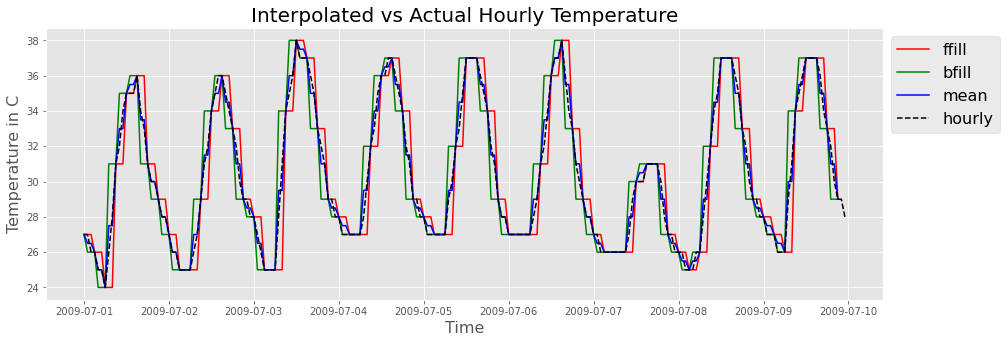

In [307]:
# Plot the resampling results for temperature
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(resample_by_ffill.index, resample_by_ffill.tempC, label = 'ffill', c = 'r')
plt.plot(resample_by_bfill.index, resample_by_bfill.tempC, label = 'bfill', c = 'g')
plt.plot(resample_by_mean.index, resample_by_mean.tempC, label = 'mean', c = 'b')
plt.plot(hourly_subset.index, hourly_subset.tempC, label = 'hourly', c = 'k',linestyle = '--')
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Temperature in C', fontsize = 16)
plt.title('Interpolated vs Actual Hourly Temperature', fontsize = 20)
plt.legend(bbox_to_anchor = (1.0,1.0), fontsize = 16)
plt.show()

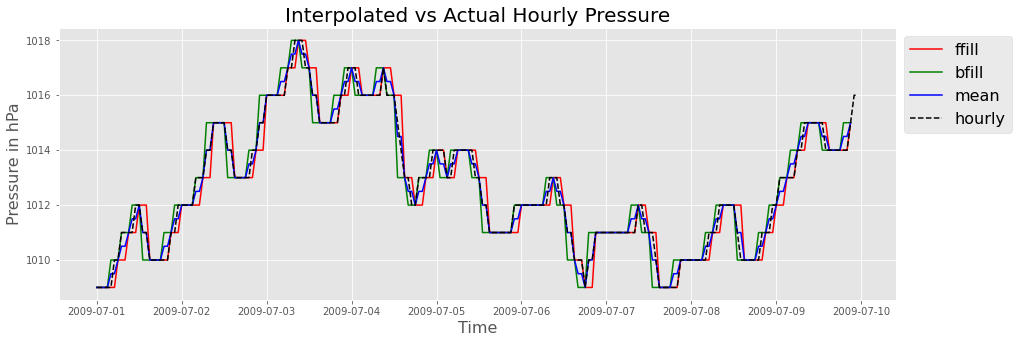

In [308]:
# Plot the resampling results for pressure
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(resample_by_ffill.index, resample_by_ffill.pressure, label = 'ffill', c = 'r')
plt.plot(resample_by_bfill.index, resample_by_bfill.pressure, label = 'bfill', c = 'g')
plt.plot(resample_by_mean.index, resample_by_mean.pressure, label = 'mean', c = 'b')
plt.plot(hourly_subset.index, hourly_subset.pressure, label = 'hourly', c = 'k',linestyle = '--')
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Pressure in hPa', fontsize = 16)
plt.title('Interpolated vs Actual Hourly Pressure', fontsize = 20)
plt.legend(bbox_to_anchor = (1.0,1.0), fontsize = 16)
plt.show()

The interpolated hourly temperature and pressure using the average of ffill and bfill methods matches the actual hourly data better than the interpolation using ffill or bfill alone. Therefore we will interpolation the weather history data from 3 hour frequency to 1 hour frequency using the average of the ffill and bfill interpolation methods. 

For the category values, we will use the results of ffill interpolation as we can not take the average of a categorical values

#### 2.4.3.5 Interpolate the whole weather data

In [309]:
# First create a dataframe grouped by regions and then assign each df by region into a dictionary
weather_dict = {}
weather_by_region = hist_weather_cleaned.groupby('region')
regions = hist_weather_cleaned['region'].unique()
for region in regions:
    weather_dict[region] = weather_by_region.get_group(region)   

In [310]:
# Interpolating the weather data from 3hr to 1Hr frequency for all regions
for key , values in weather_dict.items():
    df_ffill = values.resample('1H').ffill()
    df_bfill = values.resample('1H').bfill()
    category = df_ffill[['region','winddir16Point','weatherCategory']]
    df_ffill.drop(columns={'region','winddir16Point','weatherCategory'}, inplace=True)
    df_bfill.drop(columns={'region','winddir16Point','weatherCategory'}, inplace=True)
    df_mean = (df_ffill + df_bfill) / 2
    df_mean['region'] = category['region']
    df_mean['winddir16Point'] = category['winddir16Point']
    df_mean['weatherCategory'] = category['weatherCategory']
    weather_dict[key] =  df_mean

In [316]:
weather_dict['Coast']

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,appr_temp,region,winddir16Point,weatherCategory
Date,,,,,,,,,,,,,,,,,,
2008-07-01 00:00:00,27.0,5.0,4.0,2.2,81.0,9.0,1018.0,15.0,30.0,23.0,27.0,9.0,30.0,1.0,31.527890,Coast,N,light_rain
2008-07-01 01:00:00,25.5,5.5,28.0,1.1,78.0,9.5,1017.5,12.0,28.0,21.0,25.5,10.5,28.0,1.0,28.862458,Coast,N,light_rain
2008-07-01 02:00:00,25.5,5.5,28.0,1.1,78.0,9.5,1017.5,12.0,28.0,21.0,25.5,10.5,28.0,1.0,28.862458,Coast,N,light_rain
2008-07-01 03:00:00,24.0,6.0,52.0,0.0,75.0,10.0,1017.0,9.0,26.0,19.0,24.0,12.0,26.0,1.0,26.197027,Coast,NE,sunny
2008-07-01 04:00:00,23.5,6.5,39.5,0.0,74.5,10.0,1017.0,10.5,25.5,18.5,23.5,13.0,25.5,3.5,25.338578,Coast,NE,sunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-19 17:00:00,34.5,16.0,271.0,0.0,37.5,10.0,1008.5,15.0,36.0,17.5,34.5,19.5,36.0,4.5,34.126648,Coast,W,cloudy
2021-06-19 18:00:00,34.0,17.0,263.0,0.0,39.0,10.0,1008.0,11.0,35.0,18.0,34.0,21.0,35.0,1.0,33.515202,Coast,W,cloudy
2021-06-19 19:00:00,32.5,14.5,249.0,0.0,44.5,10.0,1008.5,7.0,34.5,19.0,32.5,18.0,34.5,1.0,32.784515,Coast,W,cloudy


## 2.5 Load cleaned Covid19 dataset

In [328]:
# Load the cleaned and merged Covid19 data
covid19 = pd.read_csv('./modified_data/texas_combined_covid19.csv')

# Convert the Date to datetime object and set index to date 
covid19['Date'] = pd.to_datetime(covid19['Date'])
covid19.set_index('Date', inplace=True)

In [329]:
regions = {'Houston':'Coast','Tyler':'East','Midland':'Far West','Wichita Falls':'North','Dallas':'North Central',
           'Corpus Christi':'South','San Antonio':'South Central','Abilene':'West'}

covid19['region'] = covid19['region'].map(regions)
covid19 = covid19.sort_index()

In [331]:
covid19

,region,covid_confirmed,covid_deaths
Date,,,
2020-01-22,South Central,0,0
2020-01-22,West,0,0
2020-01-22,East,0,0
2020-01-22,South,0,0
2020-01-22,Far West,0,0
...,...,...,...
2021-06-19,Coast,403069,6545
2021-06-19,North Central,305400,4110
2021-06-19,South Central,225547,3611


In [583]:
covid19.index

DatetimeIndex(['2020-01-22', '2020-01-22', '2020-01-22', '2020-01-22',
               '2020-01-22', '2020-01-22', '2020-01-22', '2020-01-22',
               '2020-01-23', '2020-01-23',
               ...
               '2021-06-18', '2021-06-18', '2021-06-19', '2021-06-19',
               '2021-06-19', '2021-06-19', '2021-06-19', '2021-06-19',
               '2021-06-19', '2021-06-19'],
              dtype='datetime64[ns]', name='Date', length=4120, freq=None)

### 2.5.1 Visualizing Covid19 data

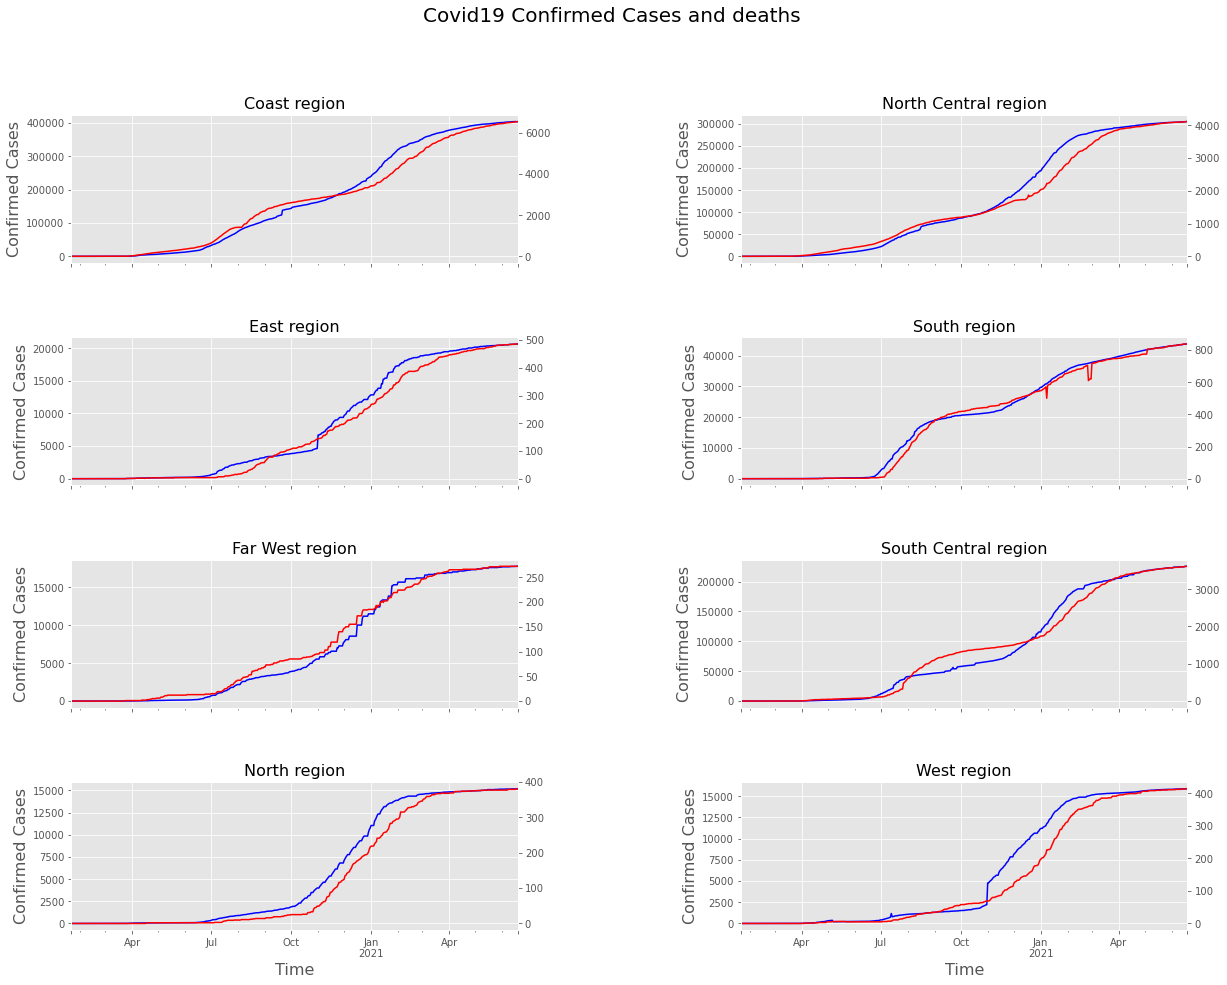

In [364]:
# plot Covi19 data
zones = ['Coast','East','Far West','North','North Central','South','South Central','West']

k = 0
fig, ax = plt.subplots(4,2,figsize=(20,15))

for i, zone in enumerate(zones) :
    if i >= 4:
        i = i - 4
        k = 1
    covid19[covid19['region']==zone]['covid_confirmed'].plot(c='b',ax=ax[i,k])
    ax2 = ax[i,k].twinx()
    covid19[covid19['region']==zone]['covid_deaths'].plot(c='r',ax=ax2)
    plt.subplots_adjust(hspace= 0.5, wspace =0.5)
    ax[i,k].set_title('%s region' %zone, fontsize=16)
    ax[i,k].set_xlabel('Time', fontsize=16)
    ax[i,k].set_ylabel('Confirmed Cases', fontsize=16)
    plt.suptitle('Covid19 Confirmed Cases and deaths', fontsize=20)
    plt.grid(None)

plt.show()

The Covid19 confirmed cases and deaths follow the same trend. In most regions, there are two inflection points where the covid cases ramped up. Covid19 cases started to go up early in July 2020. However, the major turning point was sometime in November 2021, where cases sky rocketed until February 2021. The covid19 cases seems to have plateaued starting Spring of 2021.
<p>&nbsp;</p>

### 2.5.2 Interpolate Covid19 data

In [599]:
# Resampling the covid19 data to 1H frequency
# Similar to the weather data, we create a dataframe grouped by regions and then assign each df by region into a dictionary
covid19_dict = {}
covid19_by_region = covid19.groupby('region')
regions = covid19['region'].unique()
for region in regions:
    covid19_dict[region] = covid19_by_region.get_group(region)
    covid19_dict[region] = covid19_dict[region].resample('1H').ffill()

In [668]:
# covid19_dict['Coast'][['covid_confirmed','covid_deaths']]

## 2.6 Merging weather, covid and electric load datasets

Next we will merge all the weather, covid and electric load datasets into one big dictionary. All the three data sets span different time ranges. The electric load and the weather datasets start from 2005 and mid-2008 respectively, while the covid data covers only one and half year (starting from Jan 2020). We will discard the half year data of 2008 from the weather data and keep everything starting Jan 2009. Similarly, the electric load data will be trimmed to before Jan 2009. For the time being, we will merge the Covid19 as it is and fill the empty values with 0.  

In [544]:
# First trim the electric load datasets
start_time = '2009-01-01 00:00:00'
end_time = '2021-06-19 00:00:00'

trim_hourly_load = hourly_load_cleaned[start_time : end_time]

# Check for duplicates
trim_hourly_load.index.duplicated().sum()

12

In [545]:
# drop duplicated datasets
trim_hourly_load = trim_hourly_load[~trim_hourly_load.index.duplicated(keep='last')]
trim_hourly_load.duplicated().sum()

0

In [546]:
# Set the freq of the timeseries to 'H' instead of none
# trim_hourly_load = trim_hourly_load.sort_index()

trim_hourly_load = trim_hourly_load.asfreq('H')
trim_hourly_load.fillna(method = 'ffill', inplace=True)

# Check for null values
trim_hourly_load.isnull().sum()

Coast            0
East             0
Far West         0
North            0
North Central    0
South            0
South Central    0
West             0
dates            0
hour             0
day              0
month            0
year             0
weekday          0
holiday          0
working_day      0
dtype: int64

In [612]:
# Truncate the weather data
trim_weather_dict = {}

for key, values in weather_dict.items():
    trim_weather_dict[key] = values[start_time : end_time]


In [613]:
trim_weather_dict['Coast'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109249 entries, 2009-01-01 00:00:00 to 2021-06-19 00:00:00
Freq: H
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tempC            109249 non-null  float64
 1   windspeedKmph    109249 non-null  float64
 2   winddirDegree    109249 non-null  float64
 3   precipMM         109249 non-null  float64
 4   humidity         109249 non-null  float64
 5   visibility       109249 non-null  float64
 6   pressure         109249 non-null  float64
 7   cloudcover       109249 non-null  float64
 8   HeatIndexC       109249 non-null  float64
 9   DewPointC        109249 non-null  float64
 10  WindChillC       109249 non-null  float64
 11  WindGustKmph     109249 non-null  float64
 12  FeelsLikeC       109249 non-null  float64
 13  uvIndex          109249 non-null  float64
 14  appr_temp        109249 non-null  float64
 15  region           109249 non-null  object 
 

In [614]:
# Merging weather, electric load and the covid19 data
col_list = ['dates','hour','day','month','year','weekday','holiday','working_day']
for zone in zones:
    trim_weather_dict[zone] = trim_weather_dict[zone].join\
    (trim_hourly_load[[zone,'dates','hour','day','month','year','weekday','holiday','working_day']], how='left')
    trim_weather_dict[zone].rename(columns={zone:'load'}, inplace=True)
    trim_weather_dict[zone] = trim_weather_dict[zone].join\
    (covid19_dict[zone][['covid_confirmed','covid_deaths']],how='left')
    trim_weather_dict[zone].fillna(value=0, inplace=True)

In [617]:
trim_weather_dict['Coast']

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,...,dates,hour,day,month,year,weekday,holiday,working_day,covid_confirmed,covid_deaths
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,10.0,13.0,64.0,0.00,72.0,10.0,1022.0,17.0,10.0,5.0,...,2009-01-01,0.0,1.0,1.0,2009.0,Thursday,1.0,0.0,0.0,0.0
2009-01-01 01:00:00,9.0,12.5,64.0,0.00,75.5,10.0,1022.0,18.5,9.0,5.0,...,2009-01-01,1.0,1.0,1.0,2009.0,Thursday,1.0,0.0,0.0,0.0
2009-01-01 02:00:00,9.0,12.5,64.0,0.00,75.5,10.0,1022.0,18.5,9.0,5.0,...,2009-01-01,2.0,1.0,1.0,2009.0,Thursday,1.0,0.0,0.0,0.0
2009-01-01 03:00:00,8.0,12.0,64.0,0.00,79.0,10.0,1022.0,20.0,8.0,5.0,...,2009-01-01,3.0,1.0,1.0,2009.0,Thursday,1.0,0.0,0.0,0.0
2009-01-01 04:00:00,8.0,11.0,49.0,0.00,82.5,10.0,1021.5,24.0,8.0,5.0,...,2009-01-01,4.0,1.0,1.0,2009.0,Thursday,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-18 20:00:00,30.5,23.5,57.5,0.65,69.5,9.5,1008.0,76.5,33.5,20.0,...,2021-06-18,20.0,18.0,6.0,2021.0,Friday,0.0,1.0,402916.0,6540.0
2021-06-18 21:00:00,29.0,23.0,48.0,1.10,82.0,9.0,1008.0,92.0,32.0,21.0,...,2021-06-18,21.0,18.0,6.0,2021.0,Friday,0.0,1.0,402916.0,6540.0
2021-06-18 22:00:00,29.0,13.5,158.5,0.55,73.5,9.5,1009.0,50.0,32.0,21.5,...,2021-06-18,22.0,18.0,6.0,2021.0,Friday,0.0,1.0,402916.0,6540.0


In [667]:
# print(trim_weather_dict['West'])

## 2.7 Saving datasets

In [ ]:
save_obj('./modified_data',trim_weather_dict)

In [ ]:
# Save the final merged datasets
# trim_weather_dict conatains all the data after merging weather,load and covid19 datasets
np.save('./modified_data/trim_weather_dict.npy', trim_weather_dict) 

In [663]:
# Save other intermediate datastes
np.save('./modified_data/weather_dict.npy', weather_dict) # contains only weather data
np.save('./modified_data/covid19_dict.npy', covid19_dict) # contains only covid19 data

trim_hourly_load.to_csv('./modified_data/trim_hourly_load.csv',date_format='%Y-%m-%d %H:%M:%S')


In [665]:
# Reading back the saved file to check it was written as intended
read_weather = np.load('./modified_data/trim_weather_dict.npy',allow_pickle='TRUE').item()
# print(read_weather['Coast'] == trim_weather_dict['Coast'])

## 2.8 Summary

In this notebook we read back the cleaned electric, weather and covid19 datasets. A more comprehensive data visualization was done for the Electric load data. Some of the observations include:

- The average hourly energy consumption plot for all regions is similar. The energy demand is low during the night hours and then it starts to go up starting the morning hours and increase steadily through out the day with the peak demand around late evening.
- All the regions have the highest demand during the summer months with peak demand around July and August.
- The yearly average energy demand show some variability between regions.
	- All the regions except, the North, show steady increase in energy demand until 2019 or 2020 in some cases.
    - The plot for the North region is a strange one. Energy consumption was very high around 2005 - 2008 and it decrease sharply by about 30% in 2009 and it remains almost flat after wards.
- The histogram and density plots show the distribution of the electric load is mostly uni-modal witha right tail, with the exception of Far West which show a tri-modal distribution.
	- With the exception of the North region, all other regions distribution shifted to the right as we move from 2005 to 2021, indicating increase in energy consumption with time. The North region however shows opposite of this trend. The density distribution shifted to the left after 2008 and remained stead after that.
    - the Far West region's density distribution shifted to the right but with different shift rate. It shows steady shift to the right from 2005 to 2011, then there is a big lateral shift to the right starting 2014. Also the rate of shift seems to increase every year. This was also observed in the average yearly energy consumption plot. The upward trend observed seems to have some exponential trend to it.
- The median electric load remains steady from Monday to Friday and decreases over the weekend. This reduction in energy consumption over the weekend is mostly due to closure of industries and offices for the week end. 
	- Again the Far West region shows different behavior, the week end energy consumption does not change that much from the other working days. 
    - If any give day happens to be a holiday, its energy consumption is lower than similar working day. Another observation is if the holiday happens to be on Monday (which makes it a long-weekend), the energy demand does not differ that much from a working Monday.
    
We have also interpolated the weather and covid19 datasets to 1 hour frequency, so that we can merge all the datasets easily. Both forward fill and mean of conssecutive value interpolation schemes were tested for the weather data. The interpolation using mean matched the actual hourly weather data better and hence it was used to interpolating the whole weather data

Finally, all the three datasets are merged into one big dictionary where each region is defined as a key.

In the next notebook, we will perform some pre-processing on the data and start model building